<a href="https://colab.research.google.com/github/Visheshs3/issat_project/blob/main/issatProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ISSAT PROJECT**

In [1]:
# Install the Earth Engine API and authenticate
!pip install earthengine-api
!earthengine authenticate

E0000 00:00:1746436850.227835     869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746436850.238383     869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0505 09:21:03.062212 132234323476480 _default.py:711] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20h

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime
import folium
import geemap
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import os
!pip install rasterio
import rasterio
from rasterio.merge import merge
import geopandas as gpd
from google.colab import drive
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from rasterio import features

# Initialize the Earth Engine API
ee.Initialize()

**Visualizing AOI**

In [6]:
Map = geemap.Map(center=[12.2958, 76.6394], zoom=10)

# Define center and ROI
mysoreCenter = ee.Geometry.Point([76.6394, 12.2958])
aoi = mysoreCenter.buffer(30000)

# Add to the map
Map.addLayer(mysoreCenter, {'color': 'red'}, 'Mysore Center')
Map.addLayer(aoi, {'color': 'blue'}, '30 km AOI')
Map

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# **Load Satellite Data**

# Applying Scalling Factors

In [7]:
# Define Landsat scaling factor
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    image = image.addBands(optical_bands, None, True)
    image = image.addBands(thermal_bands, None, True)
    return image

In [8]:
#removing excess cloud

def maskL8sr(image):
    # Bits 3 and 4 are cloud and cloud shadow, respectively.
    qa = image.select('QA_PIXEL')
    cloud_bit_mask = (1 << 3)  # Cloud
    cloud_shadow_bit_mask = (1 << 4)  # Cloud shadow

    # Both flags should be set to zero (i.e., no cloud and no shadow).
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0))

    return image.updateMask(mask)

# Layering True color Composite

In [9]:
data = [['2014-10-01', '2014-12-31', 'LANDSAT/LC08/C02/T1_L2'],
        ['2019-10-01', '2019-12-31', 'LANDSAT/LC08/C02/T1_L2'],
        ['2024-10-01', '2024-12-31', 'LANDSAT/LC08/C02/T1_L2']]
def sattelite_visualizaton(start_date, end_date, collection):
    image =  ee.ImageCollection(collection) \
             .filterBounds(aoi) \
             .filterDate(start_date, end_date) \
             .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
             .map(apply_scale_factors) \
             .map(maskL8sr) \
             .median() \
             .clip(aoi)
    return image



In [10]:
Map = geemap.Map(center=[12.2958, 76.6394], zoom=9)
# Load Landsat-8 Data
for start, end, collection in data:
    image = sattelite_visualizaton(start, end, collection)
    Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, f"{start} - {end}")
Map

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# **Classification Using QDA**

# Confusion Matrix

In [11]:
gdf = gpd.read_file('/content/drive/MyDrive/issat_proj/ISSAT_Proj_Training.geojson')
df = pd.DataFrame(gdf.drop(columns='geometry'))

features = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'NDVI', 'NDBI', 'MNDWI', 'BSI']
X = df[features]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_pred = qda.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

DataSourceError: /content/drive/MyDrive/issat_proj/ISSAT_Proj_Training.geojson: No such file or directory

# Classification

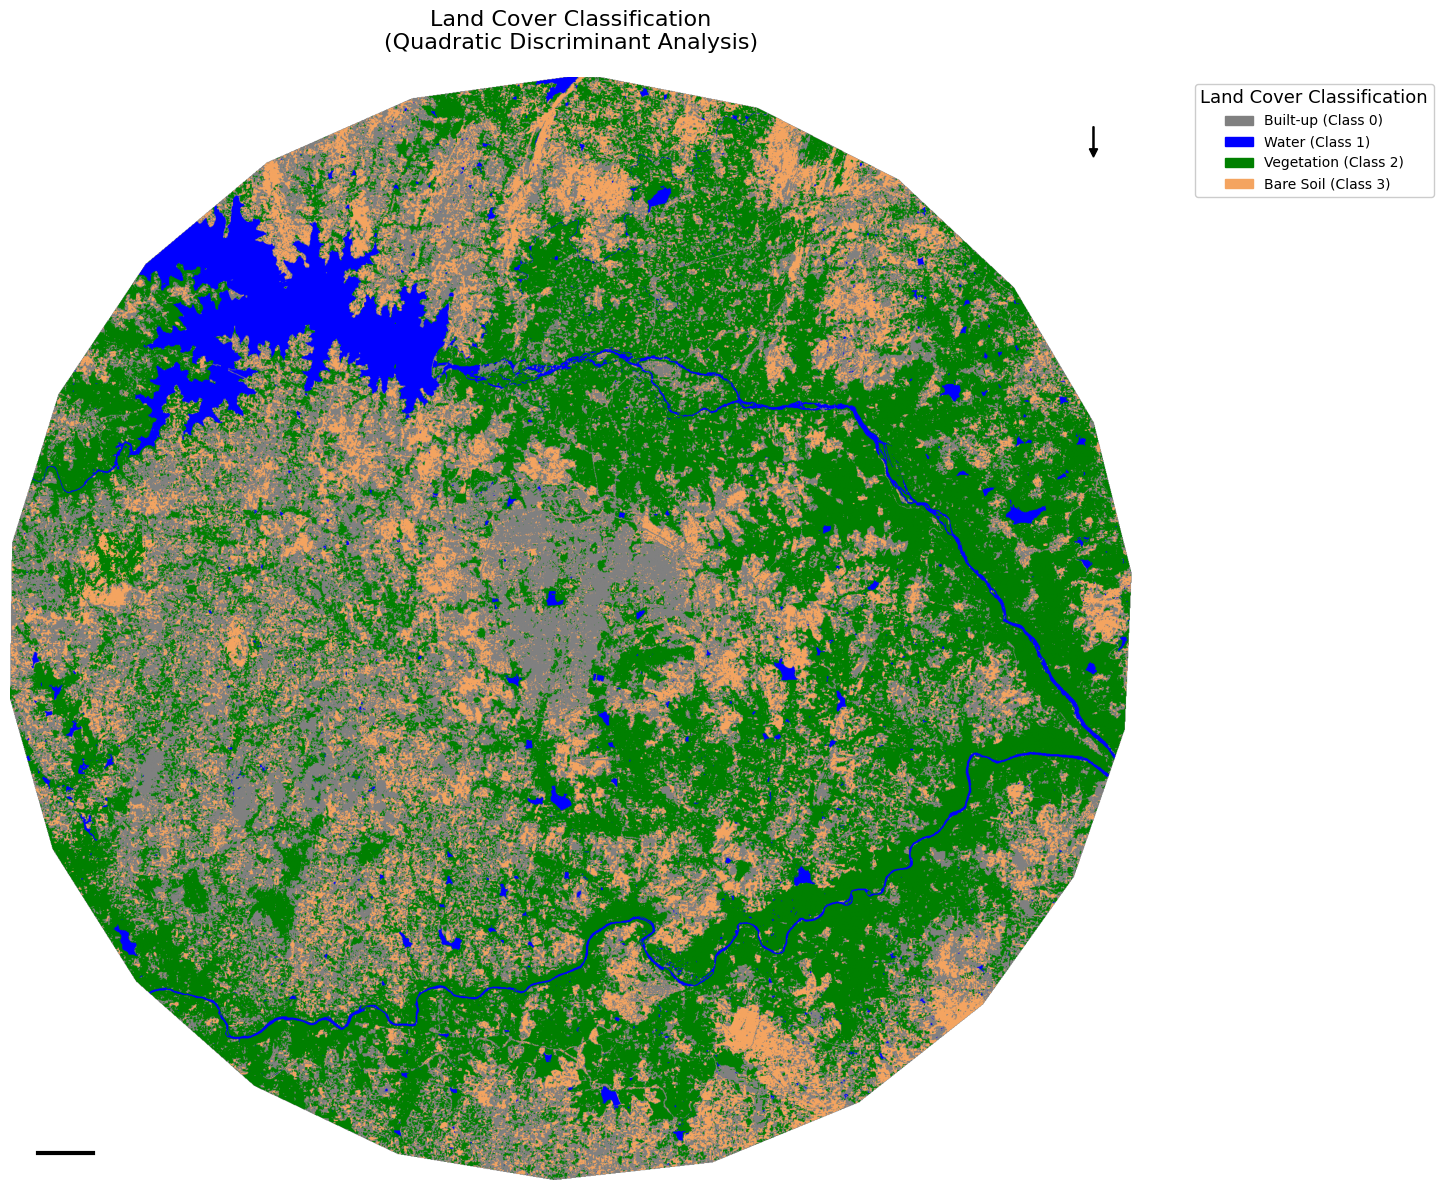

In [ ]:

with rasterio.open('/content/drive/MyDrive/issat_proj/imageForClassif.tif') as src:
    image_data = src.read()
    profile = src.profile

height, width = image_data.shape[1:]
reshaped = image_data.reshape(image_data.shape[0], -1).T
reshaped = np.nan_to_num(reshaped, nan=0)



qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

predicted = qda.predict(reshaped)



## 1. Prepare the classification result
classification_result = predicted.reshape(height, width)

## Apply Masking (NEW ADDITION)
# Load your shapefile
aoi_shp = gpd.read_file('/content/drive/MyDrive/issat_proj/Mysore_30km_Buffer_Export.shp')

# Create mask
with rasterio.open('/content/drive/MyDrive/issat_proj/imageForClassif.tif') as src:
    if aoi_shp.crs != src.crs:
        aoi_shp = aoi_shp.to_crs(src.crs)
    mask = rasterio.features.geometry_mask(
        aoi_shp.geometry,
        out_shape=src.shape,
        transform=src.transform,
        invert=True  # True=keep area inside shapefile
    )

# Apply mask to classification
masked_result = np.where(mask, classification_result, np.nan)  # Set outside AOI to transparent

## 2. Set up class visualization parameters
class_info = {
    0: {'name': 'Built-up', 'color': 'gray'},
    1: {'name': 'Water', 'color': 'blue'},
    2: {'name': 'Vegetation', 'color': 'green'},
    3: {'name': 'Bare Soil', 'color': 'sandybrown'}
}

# Create colormap and normalization
colors = [class_info[i]['color'] for i in range(4)]
cmap = ListedColormap(colors)
bounds = [0, 1, 2, 3, 4]
norm = plt.Normalize(vmin=0, vmax=4)

## 3. Create professional visualization
plt.figure(figsize=(14, 12))

# Display MASKED classified image (ONLY CHANGE)
img = plt.imshow(masked_result, cmap=cmap, norm=norm)

# Create enhanced legend
legend_elements = [
    mpatches.Patch(color=class_info[i]['color'],
                   label=f"{class_info[i]['name']} (Class {i})")
    for i in range(4)
]

legend = plt.legend(handles=legend_elements,
                   bbox_to_anchor=(1.05, 1),
                   loc='upper left',
                   title='Land Cover Classification',
                   title_fontsize='13',
                   framealpha=1)

# Add map elements
plt.title('Land Cover Classification\n(Quadratic Discriminant Analysis)',
          fontsize=16, pad=20)
plt.axis('off')

# Add scale bar
scale_length = 100  # pixels
plt.plot([50, 50 + scale_length], [height - 50, height - 50],
         color='black', linewidth=3)

plt.arrow(width - 70, 90, 0, 40, color='black',
          head_width=15, head_length=15, width=2)

plt.tight_layout()
plt.show()

# ## 4. Save the classified raster
# profile.update(
#     dtype=rasterio.uint8,
#     count=1,
#     nodata=255
# )

# output_path = '/content/drive/MyDrive/issat_proj/landcover_qda.tif'
# with rasterio.open(output_path, 'w', **profile) as dst:
#     dst.write(classification_result.astype(rasterio.uint8), 1)
# print(f"Classification saved to {output_path}")


# **Indexed Based Classification**

# TASK 3



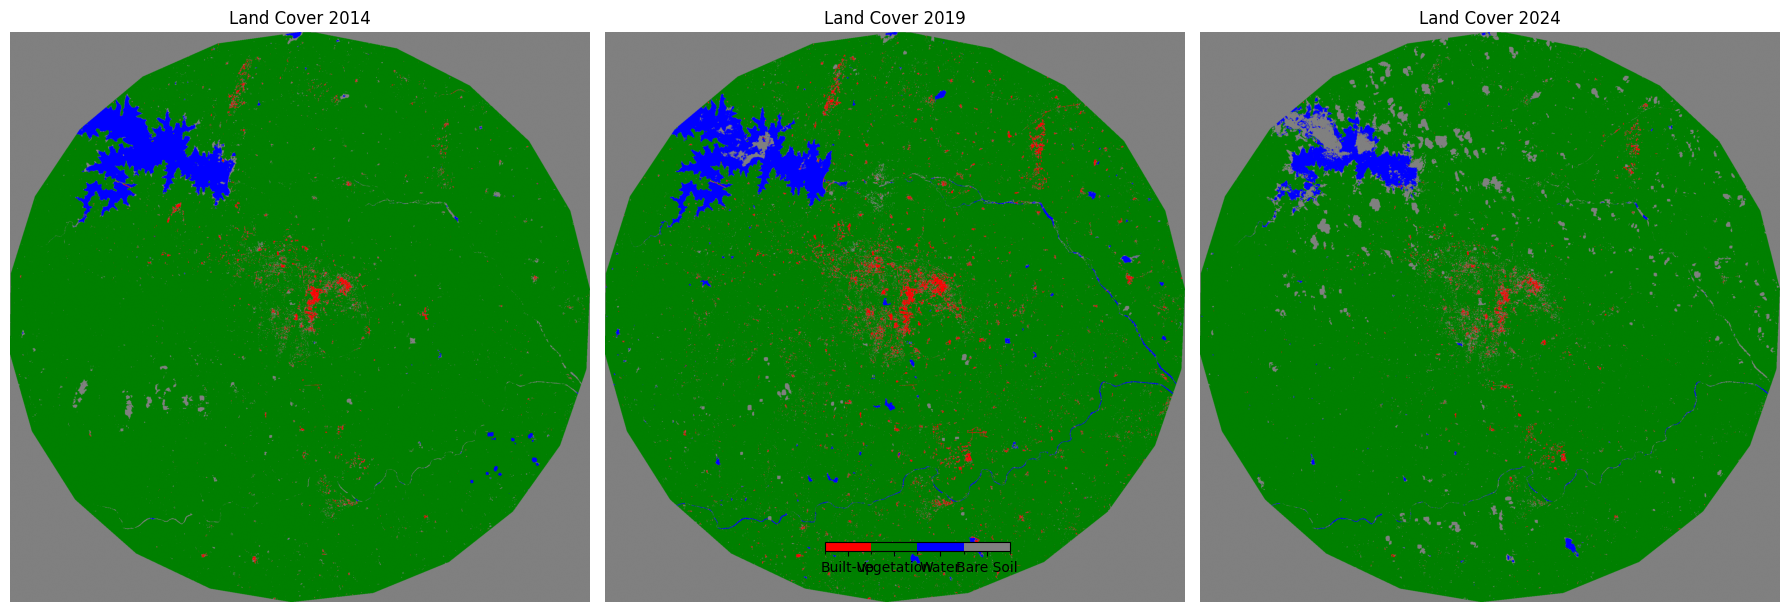

In [37]:
from matplotlib.colors import ListedColormap, BoundaryNorm
# Adjusted data thresholds
data = [
    ['2014-10-01', '2014-12-31', 'LANDSAT/LC08/C02/T1_L2', -0.5],
    ['2019-10-01', '2019-12-31', 'LANDSAT/LC08/C02/T1_L2', -0.5],
    ['2024-10-01', '2024-12-31', 'LANDSAT/LC08/C02/T1_L2', -0.5]
]

images = []
for i in data:
    # Load and preprocess image
    image = sattelite_visualizaton(i[0], i[1], i[2])
    # Create AOI mask
    aoi_mask = ee.Image.constant(1).clip(aoi).mask()

    # Improved cloud mask using QA_PIXEL
    qa = image.select('QA_PIXEL').int()
    cloud_shadow = qa.bitwiseAnd(1 << 3).neq(0)  # Bit 3: Cloud shadow
    clouds = qa.bitwiseAnd(1 << 4).neq(0)       # Bit 4: Cloud
    cloud_mask = cloud_shadow.Or(clouds)

    # Combine masks
    final_mask = aoi_mask.And(cloud_mask.Not()).And(image.select('SR_B5').mask())

    # Calculate indices
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    mndwi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

    # BSI calculation
    swir1 = image.select('SR_B6')
    red = image.select('SR_B4')
    nir = image.select('SR_B5')
    blue = image.select('SR_B2')
    bsi = (swir1.add(red).subtract(nir.add(blue))) \
          .divide(swir1.add(red).add(nir).add(blue)) \
          .rename('BSI')

    # Classification logic
    # Water (higher MNDWI threshold)
    water = mndwi.gt(0.4).And(ndvi.lt(0.15))

    # Vegetation (lower NDVI threshold)
    vegetation = ndvi.gt(0.3)

    # Built-up (adjusted conditions)
    builtup = (
        ndbi.gt(i[3])
        .And(ndvi.lt(0.25))
        .And(mndwi.lt(0.2))
        .And(water.Not())
        .And(vegetation.Not())
        .And(bsi.gt(0.1))
        .And(cloud_mask.Not())
    )

    # Create classified image
    classified = (
        ee.Image(3)  # Start with bare soil (3)
        .where(water, 2)  # Water (2)
        .where(vegetation, 1)  # Vegetation (1)
        .where(builtup, 0)  # Built-up (0)
        .updateMask(final_mask)
        .clip(aoi)
        .rename('classification')
    )

    # Export to NumPy
    img_np = geemap.ee_to_numpy(
        classified,
        region=aoi,
        scale=30
    )
    img_np = np.squeeze(img_np)

    # Enhanced masking
    img_np = np.ma.masked_where((img_np < 0) | (img_np > 3), img_np)
    images.append(img_np)

# Visualization parameters
colors = ['red', 'green', 'blue', 'gray']  # Built-up, Vegetation, Water, Bare soil
cmap = ListedColormap(colors)
class_bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(class_bounds, cmap.N)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, title, img in zip(axes, ['2014', '2019', '2024'], images):
    mappable = ax.imshow(img, cmap=cmap, norm=norm)
    ax.set_title(f'Land Cover {title}', fontsize=12)
    ax.axis('off')

# Add unified colorbar
cbar = fig.colorbar(mappable, ax=axes, orientation='horizontal',
                    fraction=0.02, pad=0.01)
cbar.set_ticks([0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(['Built-up', 'Vegetation', 'Water', 'Bare Soil'])
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.show()

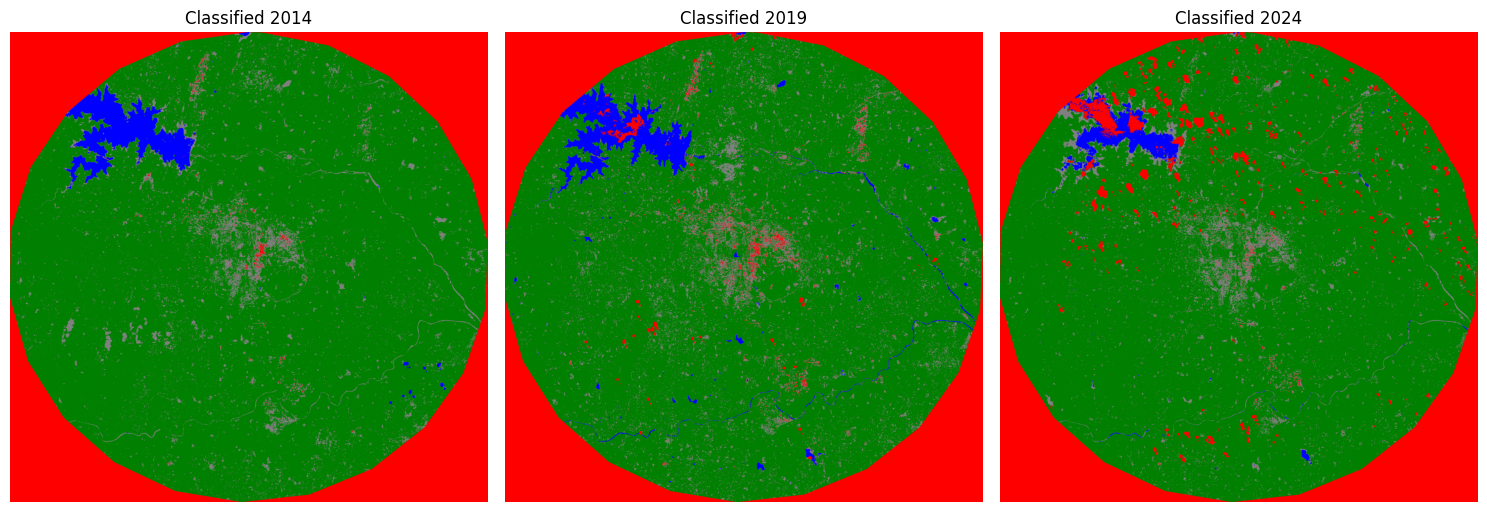

In [26]:
colors = ['red', 'green', 'blue', 'gray']
cmap = ListedColormap(colors)

# Plotting using custom colors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ['2014', '2019', '2024']
for i in range(3):
    axes[i].imshow(images[i], cmap=cmap, vmin=0, vmax=3)
    axes[i].set_title(f'Classified {titles[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
IndexedMap = geemap.Map(center=[12.2958, 76.6394], zoom=9)

IndexedMap.add_layer(classified, {'min': 0, 'max': 3, 'palette': ['red', 'green', 'blue', 'gray']}, 'Index-based Classification')

IndexedMap

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
import math

# Function to create a sector polygon from angle and radius
def create_sector(center, start_angle, angle_width, radius):
    coords = []

    # Convert angles to radians
    start = math.radians(start_angle)
    end = math.radians(start_angle + angle_width)

    # Number of points to draw the arc
    steps = 30
    for i in range(steps + 1):
        angle = start + (end - start) * i / steps
        x = center.coordinates().get(0).getInfo() + radius * math.cos(angle) / 111320
        y = center.coordinates().get(1).getInfo() + radius * math.sin(angle) / 110540
        coords.append([x, y])

    # Close the sector back to center
    coords.insert(0, center.coordinates().getInfo())
    coords.append(center.coordinates().getInfo())

    return ee.Feature(ee.Geometry.Polygon([coords]))

# Create 8 sectors (45 degrees each)
sectors = ee.FeatureCollection([
    create_sector(mysoreCenter, i * 45, 45, 30000)
    for i in range(8)
])

In [ ]:
SectoredMap=geemap.Map(center=[12.2958, 76.6394], zoom=9)
SectoredMap.add_layer(sectors, {}, '45° Sectors')
SectoredMap

#Map.add_layer(sectors, {}, '45° Sectors')

Map(center=[12.2958, 76.6394], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [ ]:
# Create binary masks
urban = classified.eq(0).rename('urban')
veg = classified.eq(1).rename('vegetation')
water = classified.eq(2).rename('water')
others = classified.eq(3).rename('others')

# Combine into multi-band image
classes = ee.Image.cat([urban, veg, water, others])

# Multiply by pixel area (hectares)
area_image = classes.multiply(ee.Image.pixelArea().divide(10000))

# Now reduce per sector
sector_stats = area_image.reduceRegions(
    collection=sectors,
    reducer=ee.Reducer.sum().repeat(4),  # because 4 bands
    scale=30,
    tileScale=4
)

for f in sector_stats.getInfo()['features']:
    print(f"Sector:")
    print(f"Urban : {f['properties']['sum'][0]:.2f} hectare")
    print(f"Vegetaion : {f['properties']['sum'][1]:.2f} hectare")
    print(f"Water : {f['properties']['sum'][2]:.2f} hectare")
    print(f"Others : {f['properties']['sum'][3]:.2f} hectare")
    print()

Sector:
Urban : 2090.05 hectare
Vegetaion : 29314.16 hectare
Water : 381.94 hectare
Others : 2767.38 hectare

Sector:
Urban : 3973.07 hectare
Vegetaion : 27034.03 hectare
Water : 158.67 hectare
Others : 2968.55 hectare

Sector:
Urban : 3580.91 hectare
Vegetaion : 19938.97 hectare
Water : 5791.19 hectare
Others : 4784.78 hectare

Sector:
Urban : 2452.11 hectare
Vegetaion : 26222.87 hectare
Water : 2860.52 hectare
Others : 3017.94 hectare

Sector:
Urban : 2604.59 hectare
Vegetaion : 28606.74 hectare
Water : 46.64 hectare
Others : 3307.17 hectare

Sector:
Urban : 2484.09 hectare
Vegetaion : 28914.71 hectare
Water : 242.24 hectare
Others : 2508.02 hectare

Sector:
Urban : 3485.14 hectare
Vegetaion : 26544.47 hectare
Water : 234.00 hectare
Others : 3855.63 hectare

Sector:
Urban : 1760.29 hectare
Vegetaion : 29184.23 hectare
Water : 491.06 hectare
Others : 3129.65 hectare



#Calculating LST using Mono Window Algorithm

**Satellite data used is LANDSAT/LC08/C02/T1**

which has raw reflectance data to apply Mono Window Algorithm

# Mono Window Algorithm

In [ ]:
def calc_radiance(img, band, mult_key, add_key):
    return img.select(band) \
        .multiply(ee.Number(img.get(mult_key))) \
        .add(ee.Number(img.get(add_key)))

def apply_mono_window(img):
    k1 = ee.Number(img.get('K1_CONSTANT_BAND_10'))
    k2 = ee.Number(img.get('K2_CONSTANT_BAND_10')) # thermalconstants of image

    var_radiance = calc_radiance(img, 'B10', 'RADIANCE_MULT_BAND_10','RADIANCE_ADD_BAND_10') # radiance for B10
    # calculating ndvi
    ref4 = calc_radiance(img, 'B4', 'REFLECTANCE_MULT_BAND_4', 'REFLECTANCE_ADD_BAND_4')
    ref5 = calc_radiance(img, 'B5', 'REFLECTANCE_MULT_BAND_5', 'REFLECTANCE_ADD_BAND_5')
    ndvi = ref5.subtract(ref4).divide(ref5.add(ref4)).rename('NDVI')
    bt = var_radiance.expression(            # calculating bt(brightness temp)
        '(k2 / log(k1 / L + 1)) - 273.15', {
          'k1': k1,
          'k2': k2,
          'L': var_radiance
    }).rename('BT')

    # Calculate PV and Emissivity
    pv = ndvi.subtract(-1).divide(2)
    pv = pv.pow(2).rename('PV')
    emissivity = pv.multiply(0.004).add(0.986).rename('Emissivity')

    # Calculate LST
    lst = bt.divide(
      ee.Image(1).add(
        bt.multiply(10.4e-6).divide(1.438e-2).multiply(emissivity.log())
      )
    ).rename('LST')

    return img.addBands(lst, None, True)



# Map

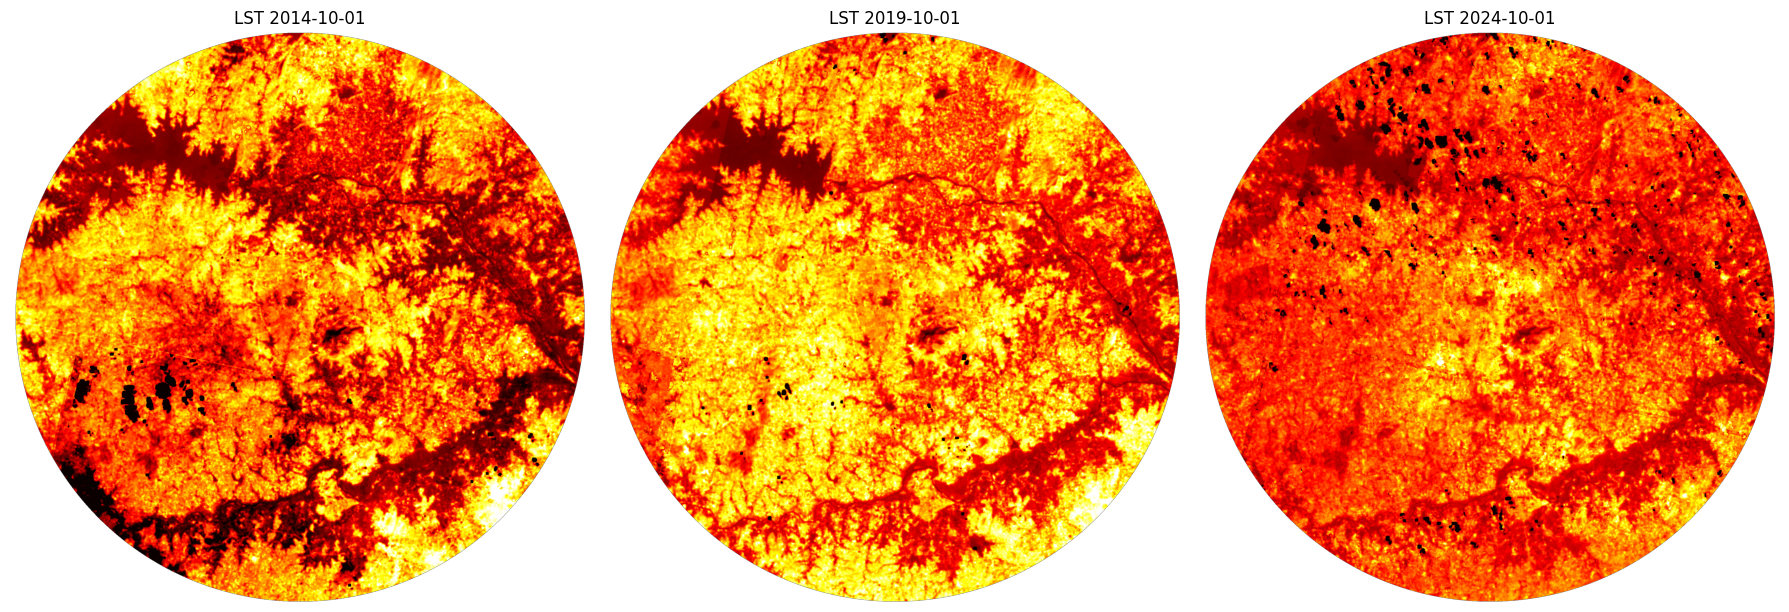

In [ ]:
# Add layers to the map

LSTMap= geemap.Map()
LSTMap.centerObject(mysoreCenter, 10)
LSTMap.addLayer(mysoreCenter, {'color': 'red'}, 'Mysore Center')

data = [['2014-10-01', '2014-12-31', 'LANDSAT/LC08/C02/T1'],
        ['2019-10-01', '2019-12-31', 'LANDSAT/LC08/C02/T1'],
        ['2024-10-01', '2024-12-31', 'LANDSAT/LC08/C02/T1']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (start, end, collection) in enumerate(data):
  image = (ee.ImageCollection(collection)
             .filterBounds(aoi)
             .filterDate(start, end)
             .filter(ee.Filter.lt('CLOUD_COVER', 20))
             .map(apply_mono_window)
             .map(maskL8sr)
             .median()
             .clip(aoi))

  # Add layers to map
  arr = geemap.ee_to_numpy(image.select('LST'), region=aoi, scale=30)
  arr = np.squeeze(arr)

  # Generate true circular mask for 30 km radius
  h, w = arr.shape
  y, x = np.ogrid[:h, :w]
  center_y, center_x = h // 2, w // 2
  pixels_radius = int(30000 / 30)  # 30 km in pixels
  circular_mask = (x - center_x)**2 + (y - center_y)**2 <= pixels_radius**2
  arr[~circular_mask] = np.nan  # Mask outside circle

  axes[i].imshow(arr, cmap='hot', vmin=20, vmax=30)
  axes[i].set_title(f"LST {start}")
  axes[i].axis('off')

plt.tight_layout()
plt.show()


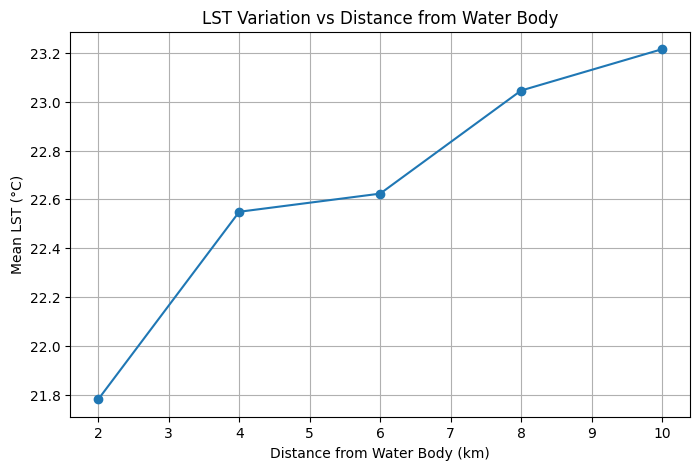

In [ ]:
water_point = ee.Geometry.Point([76.567, 12.437])

# Distances (in meters) for concentric rings: 2km to 10km
distances = [2000, 4000, 6000, 8000, 10000]

# Create concentric rings
rings = []
for d in distances:
    outer = water_point.buffer(d)
    inner = water_point.buffer(d - 2000) if d > 2000 else water_point
    rings.append(outer.difference(inner))

# Load and preprocess Landsat LST image
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1") \
    .filterBounds(water_point) \
    .filterDate("2024-10-01", "2024-12-31") \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(apply_mono_window)  # apply_mono_window should return an image with LST band

lst_image = collection.median().select("LST")

# Get mean LST for each ring
mean_lst = [
    lst_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ring,
        scale=30,
        maxPixels=1e9
    ).getInfo()["LST"] for ring in rings
]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot([2, 4, 6, 8, 10], mean_lst, marker='o')
plt.title("LST Variation vs Distance from Water Body")
plt.xlabel("Distance from Water Body (km)")
plt.ylabel("Mean LST (°C)")
plt.grid(True)
plt.show()

TASK 5: Analyzing LST vs Land Cover by Sector for 2014, 2019, and 2024
Processing 2014 data...
Processing 2019 data...
Processing 2024 data...
Extracting statistics for all sectors and time periods...
Processed Period: 2014, Sector: 0
Processed Period: 2014, Sector: 1
Processed Period: 2014, Sector: 2
Processed Period: 2014, Sector: 3
Processed Period: 2014, Sector: 4
Processed Period: 2014, Sector: 5
Processed Period: 2014, Sector: 6
Processed Period: 2014, Sector: 7
Processed Period: 2019, Sector: 0
Processed Period: 2019, Sector: 1
Processed Period: 2019, Sector: 2
Processed Period: 2019, Sector: 3
Processed Period: 2019, Sector: 4
Processed Period: 2019, Sector: 5
Processed Period: 2019, Sector: 6
Processed Period: 2019, Sector: 7
Processed Period: 2024, Sector: 0
Processed Period: 2024, Sector: 1
Processed Period: 2024, Sector: 2
Processed Period: 2024, Sector: 3
Processed Period: 2024, Sector: 4
Processed Period: 2024, Sector: 5
Processed Period: 2024, Sector: 6
Processed Period:

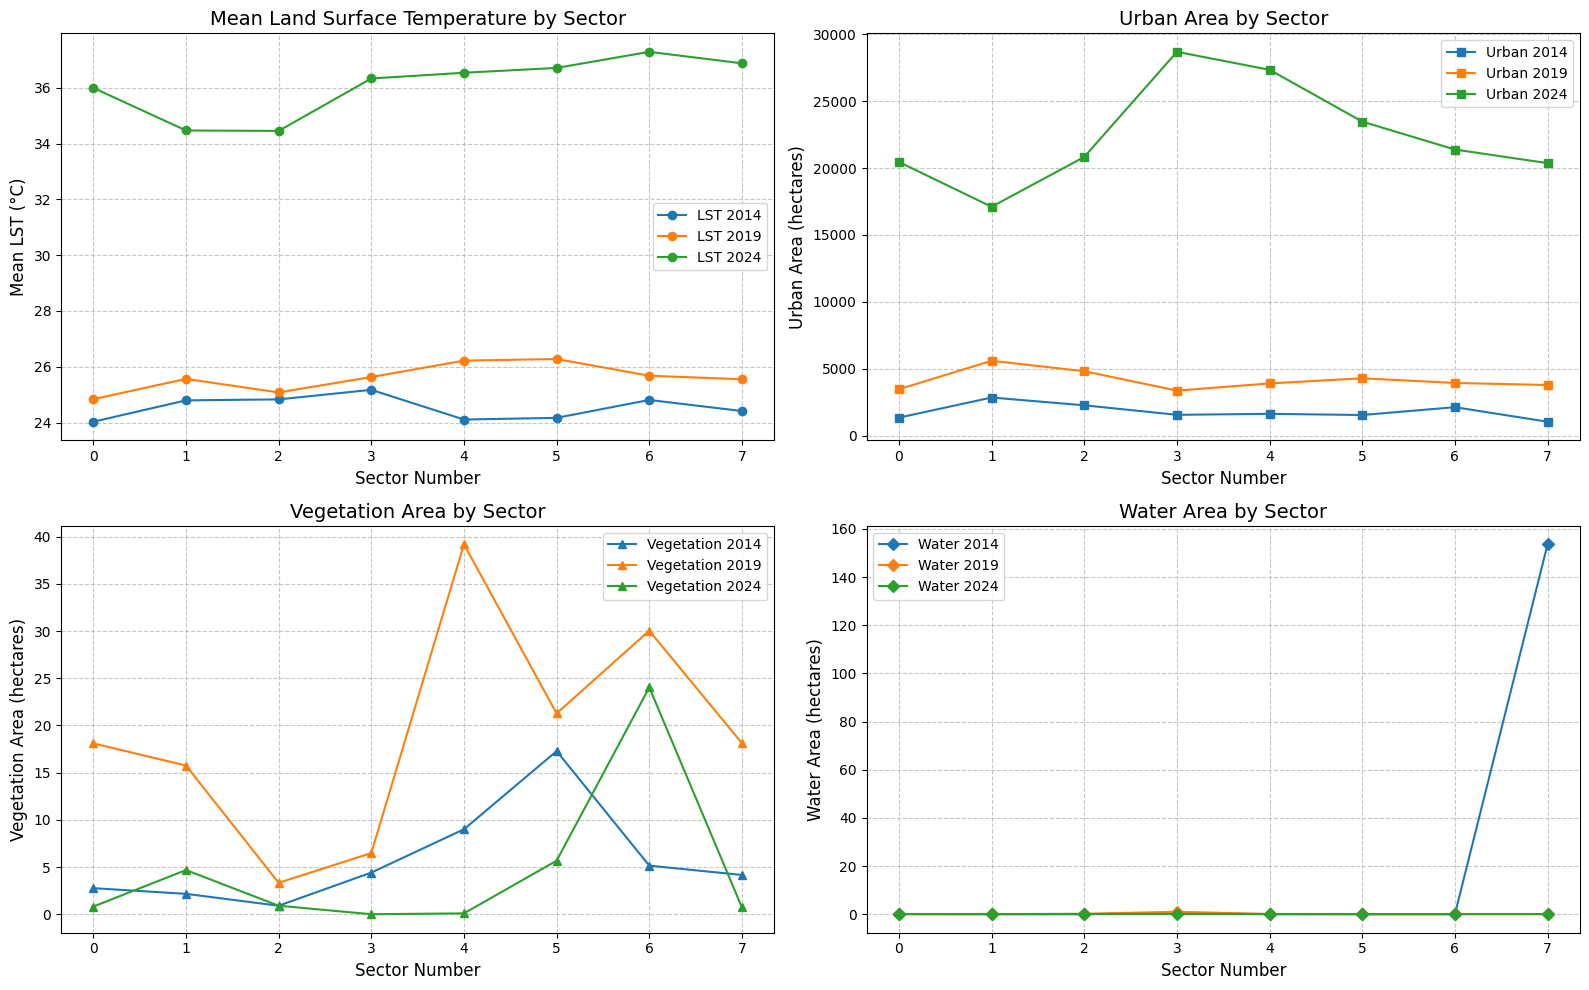

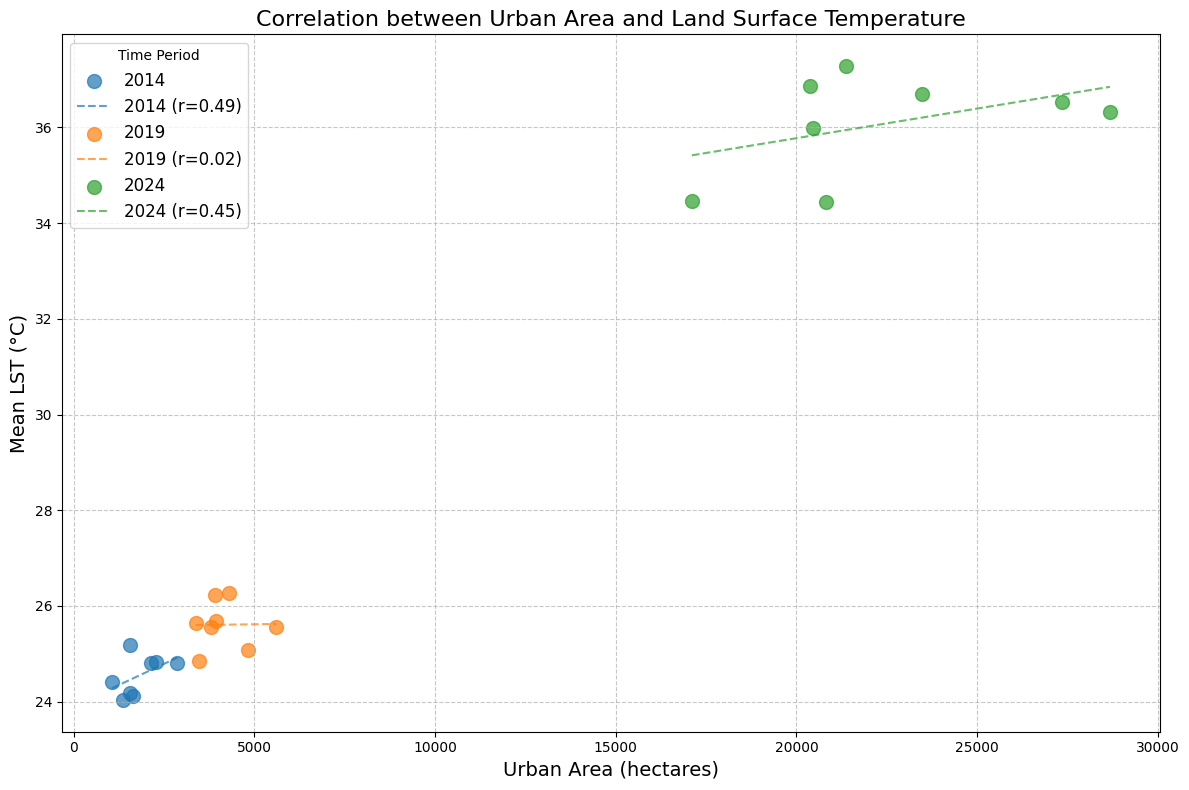

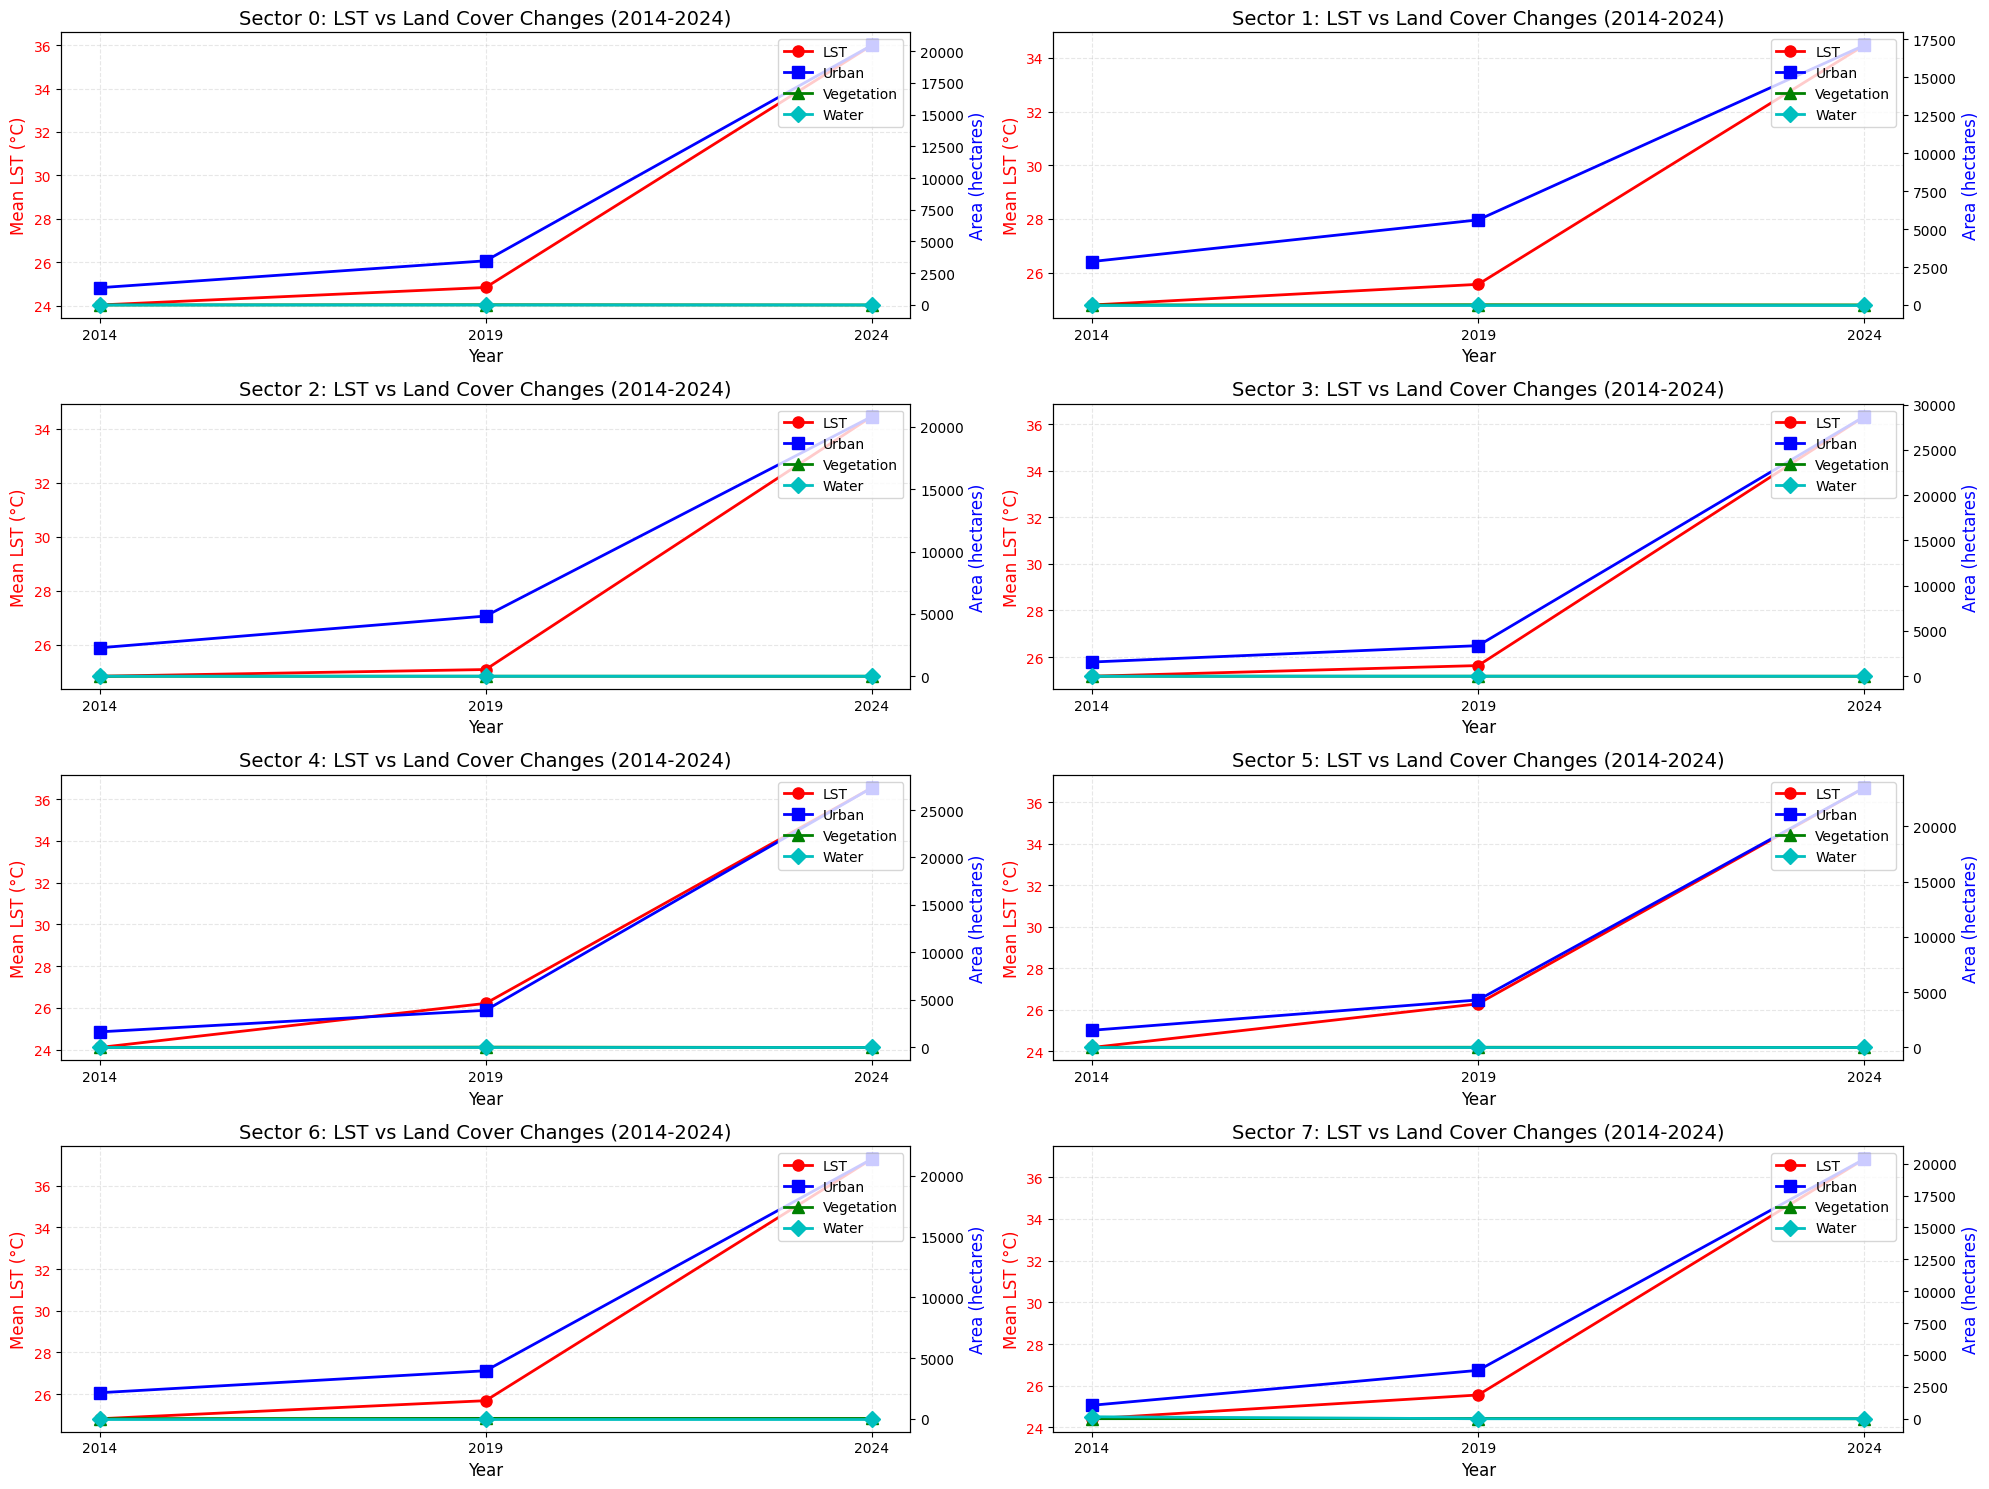


Sector Summary Table:
         LST_mean                       Urban_area_ha               \
Period       2014       2019       2024          2014         2019   
Sector                                                               
0       24.031943  24.838729  35.992545   1360.123059  3479.388706   
1       24.797484  25.567061  34.466616   2862.049765  5606.502000   
2       24.832522  25.080962  34.451381   2280.940941  4827.516706   
3       25.174221  25.632689  36.329674   1569.890471  3378.350824   
4       24.110505  26.221031  36.535204   1644.948353  3914.846824   
5       24.170432  26.279008  36.707742   1555.441412  4298.273647   
6       24.811821  25.679469  37.284766   2140.798235  3951.705882   
7       24.414958  25.555073  36.872832   1055.047412  3796.248353   

                     Vegetation_area_ha                   Water_area_ha  \
Period          2024               2014       2019   2024          2014   
Sector                                                  

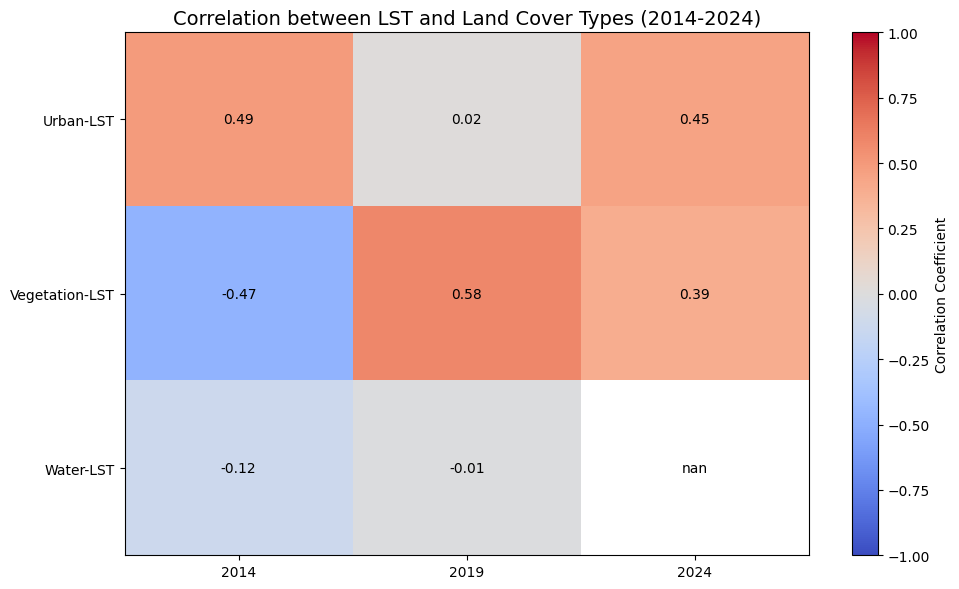

Task 5 analysis completed successfully!


In [ ]:
# TASK 5: SECTOR ANALYSIS FOR LST VS LAND COVER
print("TASK 5: Analyzing LST vs Land Cover by Sector for 2014, 2019, and 2024")

# Function to preprocess and calculate LST for a given time period
def get_lst_and_landcover(start_date, end_date):
    # Load Landsat-8 data
    image = (ee.ImageCollection("LANDSAT/LC08/C02/T1")
             .filterBounds(aoi)
             .filterDate(start_date, end_date)
             .filter(ee.Filter.lt('CLOUD_COVER', 20))
             .map(apply_mono_window)  # Apply LST calculation
             .map(maskL8sr)  # Apply cloud masking
             .median()
             .clip(aoi))

    # Calculate land cover indices
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['B6', 'B5']).rename('NDBI')
    mndwi = image.normalizedDifference(['B3', 'B6']).rename('MNDWI')

    # Classify land cover
    # Initialize all as "others" (value = 3)
    classified = ndvi.multiply(0).add(3)
    # Vegetation = 2
    classified = classified.where(ndvi.gt(0.5), 2)
    # Urban = 0
    classified = classified.where(ndbi.gt(0.0), 0)
    # Water = 1
    classified = classified.where(mndwi.gt(0.3), 1)

    # Add classification band to the image
    return image.addBands(classified.rename('landcover'))

# Create a list to store dates
time_periods = [
    {'period': '2014', 'start': '2014-10-01', 'end': '2014-12-31'},
    {'period': '2019', 'start': '2019-10-01', 'end': '2019-12-31'},
    {'period': '2024', 'start': '2024-03-01', 'end': '2024-04-30'}  # Using March-April for 2024 as Oct-Dec isn't available yet
]

# Process each time period
lst_images = []
for period in time_periods:
    print(f"Processing {period['period']} data...")
    image_with_landcover = get_lst_and_landcover(period['start'], period['end'])
    lst_images.append({'period': period['period'], 'image': image_with_landcover})

# Display a sample LST image
SampleMap = geemap.Map(center=[12.2958, 76.6394], zoom=10)
SampleMap.addLayer(
    lst_images[0]['image'].select('LST'),
    {'min': 20, 'max': 40, 'palette': ['blue', 'yellow', 'orange', 'red']},
    'LST 2014'
)
SampleMap.addLayer(
    lst_images[0]['image'].select('landcover'),
    {'min': 0, 'max': 3, 'palette': ['red', 'blue', 'green', 'gray']},
    'Land Cover 2014'
)
SampleMap

# Create 8 sectors (45 degrees each) if not already created
if 'sectors' not in locals():
    sectors = ee.FeatureCollection([
        create_sector(mysoreCenter, i * 45, 45, 30000)
        for i in range(8)
    ])

# Function to extract statistics for each sector
def extract_sector_stats(image, sector_geom, sector_id, period):
    # Get LST statistics
    lst_stats = image.select('LST').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=sector_geom,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    # Get land cover statistics
    landcover = image.select('landcover')

    # Count pixels for each class
    urban_pixels = landcover.eq(0).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=sector_geom,
        scale=30,
        maxPixels=1e9
    ).getInfo().get('landcover', 0)

    water_pixels = landcover.eq(1).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=sector_geom,
        scale=30,
        maxPixels=1e9
    ).getInfo().get('landcover', 0)

    veg_pixels = landcover.eq(2).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=sector_geom,
        scale=30,
        maxPixels=1e9
    ).getInfo().get('landcover', 0)

    other_pixels = landcover.eq(3).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=sector_geom,
        scale=30,
        maxPixels=1e9
    ).getInfo().get('landcover', 0)

    # Calculate pixel area in hectares (30m x 30m = 0.09 ha)
    pixel_area_ha = 0.09

    return {
        'Period': period,
        'Sector': sector_id,
        'LST_mean': float(lst_stats.get('LST', 0)),
        'Urban_area_ha': float(urban_pixels) * pixel_area_ha,
        'Water_area_ha': float(water_pixels) * pixel_area_ha,
        'Vegetation_area_ha': float(veg_pixels) * pixel_area_ha,
        'Others_area_ha': float(other_pixels) * pixel_area_ha,
        'Urban_pixels': float(urban_pixels),
        'Water_pixels': float(water_pixels),
        'Vegetation_pixels': float(veg_pixels),
        'Others_pixels': float(other_pixels)
    }

# Collect statistics for all sectors and periods
print("Extracting statistics for all sectors and time periods...")
sector_results = []

for period_data in lst_images:
    period = period_data['period']
    image = period_data['image']

    # Process each sector
    for i, sector_feature in enumerate(sectors.getInfo()['features']):
        # Convert to ee.Feature
        sector_geom = ee.Geometry.Polygon(sector_feature['geometry']['coordinates'])

        # Extract statistics
        stats = extract_sector_stats(image, sector_geom, i, period)
        sector_results.append(stats)

        # Print progress
        print(f"Processed Period: {period}, Sector: {i}")

# Convert to DataFrame
sector_df = pd.DataFrame(sector_results)

# Print summary statistics
print("\nSummary Statistics:")
print(sector_df.groupby('Period').mean()[['LST_mean', 'Urban_area_ha', 'Vegetation_area_ha', 'Water_area_ha']])

# Create visualizations
# 1. LST by sector and period
plt.figure(figsize=(16, 10))

# LST by sector for each period
plt.subplot(2, 2, 1)
for period in sector_df['Period'].unique():
    plt.plot(sector_df[sector_df['Period'] == period]['Sector'],
             sector_df[sector_df['Period'] == period]['LST_mean'],
             marker='o', linestyle='-', label=f'LST {period}')
plt.title('Mean Land Surface Temperature by Sector', fontsize=14)
plt.xlabel('Sector Number', fontsize=12)
plt.ylabel('Mean LST (°C)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(range(8))

# Urban area by sector for each period
plt.subplot(2, 2, 2)
for period in sector_df['Period'].unique():
    plt.plot(sector_df[sector_df['Period'] == period]['Sector'],
             sector_df[sector_df['Period'] == period]['Urban_area_ha'],
             marker='s', linestyle='-', label=f'Urban {period}')
plt.title('Urban Area by Sector', fontsize=14)
plt.xlabel('Sector Number', fontsize=12)
plt.ylabel('Urban Area (hectares)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(range(8))

# Vegetation area by sector for each period
plt.subplot(2, 2, 3)
for period in sector_df['Period'].unique():
    plt.plot(sector_df[sector_df['Period'] == period]['Sector'],
             sector_df[sector_df['Period'] == period]['Vegetation_area_ha'],
             marker='^', linestyle='-', label=f'Vegetation {period}')
plt.title('Vegetation Area by Sector', fontsize=14)
plt.xlabel('Sector Number', fontsize=12)
plt.ylabel('Vegetation Area (hectares)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(range(8))

# Water area by sector for each period
plt.subplot(2, 2, 4)
for period in sector_df['Period'].unique():
    plt.plot(sector_df[sector_df['Period'] == period]['Sector'],
             sector_df[sector_df['Period'] == period]['Water_area_ha'],
             marker='D', linestyle='-', label=f'Water {period}')
plt.title('Water Area by Sector', fontsize=14)
plt.xlabel('Sector Number', fontsize=12)
plt.ylabel('Water Area (hectares)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(range(8))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/issat_proj/sector_analysis_by_period.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Create correlation analysis for Urban area vs LST
plt.figure(figsize=(12, 8))

# Plot correlation between urban area and LST for each period
for period in sector_df['Period'].unique():
    period_data = sector_df[sector_df['Period'] == period]
    plt.scatter(
        period_data['Urban_area_ha'],
        period_data['LST_mean'],
        label=f'{period}',
        alpha=0.7,
        s=100
    )

    # Add trend line
    z = np.polyfit(period_data['Urban_area_ha'], period_data['LST_mean'], 1)
    p = np.poly1d(z)

    # Calculate correlation coefficient
    r = np.corrcoef(period_data['Urban_area_ha'], period_data['LST_mean'])[0,1]

    # Plot trend line
    x_range = np.linspace(min(period_data['Urban_area_ha']), max(period_data['Urban_area_ha']), 100)
    plt.plot(
        x_range,
        p(x_range),
        linestyle='--',
        alpha=0.7,
        label=f"{period} (r={r:.2f})"
    )

plt.title('Correlation between Urban Area and Land Surface Temperature', fontsize=16)
plt.xlabel('Urban Area (hectares)', fontsize=14)
plt.ylabel('Mean LST (°C)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Time Period', fontsize=12)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/issat_proj/LST_Urban_Correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Create dual-axis plot for each sector showing LST and land cover changes
plt.figure(figsize=(20, 15))

for i in range(8):
    plt.subplot(4, 2, i+1)

    # Filter data for this sector
    sector_data = sector_df[sector_df['Sector'] == i]

    # Primary y-axis: LST
    ax1 = plt.gca()
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Mean LST (°C)', fontsize=12, color='red')
    ax1.plot(sector_data['Period'], sector_data['LST_mean'], 'ro-', linewidth=2, markersize=8, label='LST')
    ax1.tick_params(axis='y', labelcolor='red')

    # Secondary y-axis: Land cover areas
    ax2 = ax1.twinx()
    ax2.set_ylabel('Area (hectares)', fontsize=12, color='blue')
    ax2.plot(sector_data['Period'], sector_data['Urban_area_ha'], 'bs-', linewidth=2, markersize=8, label='Urban')
    ax2.plot(sector_data['Period'], sector_data['Vegetation_area_ha'], 'g^-', linewidth=2, markersize=8, label='Vegetation')
    ax2.plot(sector_data['Period'], sector_data['Water_area_ha'], 'cD-', linewidth=2, markersize=8, label='Water')

    # Title and legend
    plt.title(f'Sector {i}: LST vs Land Cover Changes (2014-2024)', fontsize=14)

    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    # Grid
    ax1.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/issat_proj/sector_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Create a comprehensive sector summary table
sector_summary = sector_df.pivot_table(
    index='Sector',
    columns='Period',
    values=['LST_mean', 'Urban_area_ha', 'Vegetation_area_ha', 'Water_area_ha']
)

# Calculate changes
for metric in ['LST_mean', 'Urban_area_ha', 'Vegetation_area_ha', 'Water_area_ha']:
    if ('2014' in sector_summary[metric].columns) and ('2024' in sector_summary[metric].columns):
        sector_summary[(metric, 'Change_2014_2024')] = sector_summary[(metric, '2024')] - sector_summary[(metric, '2014')]
        sector_summary[(metric, 'Change_%')] = ((sector_summary[(metric, '2024')] - sector_summary[(metric, '2014')]) /
                                              sector_summary[(metric, '2014')]) * 100

# Print the summary table
print("\nSector Summary Table:")
print(sector_summary)

# Export summary to CSV
sector_summary.to_csv('/content/drive/MyDrive/issat_proj/sector_summary_table.csv')
print("Sector analysis summary saved to CSV file.")

# Create correlation matrix between LST and land cover types
correlation_data = []

for period in sector_df['Period'].unique():
    period_data = sector_df[sector_df['Period'] == period]

    # Calculate correlation coefficients
    corr_urban_lst = np.corrcoef(period_data['Urban_area_ha'], period_data['LST_mean'])[0,1]
    corr_veg_lst = np.corrcoef(period_data['Vegetation_area_ha'], period_data['LST_mean'])[0,1]
    corr_water_lst = np.corrcoef(period_data['Water_area_ha'], period_data['LST_mean'])[0,1]

    correlation_data.append({
        'Period': period,
        'Urban-LST Correlation': corr_urban_lst,
        'Vegetation-LST Correlation': corr_veg_lst,
        'Water-LST Correlation': corr_water_lst
    })

corr_df = pd.DataFrame(correlation_data)
print("\nCorrelation between LST and Land Cover Types:")
print(corr_df)

# Create correlation heatmap
plt.figure(figsize=(10, 6))
corr_matrix = np.array([
    corr_df['Urban-LST Correlation'].values,
    corr_df['Vegetation-LST Correlation'].values,
    corr_df['Water-LST Correlation'].values
])

plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr_df['Period'])), corr_df['Period'])
plt.yticks(range(3), ['Urban-LST', 'Vegetation-LST', 'Water-LST'])
plt.title('Correlation between LST and Land Cover Types (2014-2024)', fontsize=14)

for i in range(3):
    for j in range(len(corr_df['Period'])):
        plt.text(j, i, f"{corr_matrix[i,j]:.2f}", ha='center', va='center', color='black')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/issat_proj/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Task 5 analysis completed successfully!")